In [1]:
import os
import json
from uncertainties import ufloat, umath
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})
from scipy.signal import savgol_filter

from functions import Qf2σ, prettifySample, p2XS

<ipython-input-3-75a6ed9ee6a9>:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


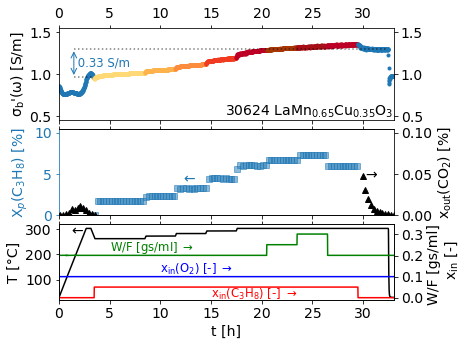

In [3]:
sids = ["01"]
colors = ["C0", "#fed976", "#feb24c", "#fd8d3c", "#f03b20", "#bd0026", "#a63603", "#a50f15", "#bd0026", "C0", "C0"]

fig = plt.figure(figsize=(6,5))
grid = plt.GridSpec(100, 100, wspace=0.1, hspace=0.1, figure=fig)
ax = []
ax.append(plt.subplot(grid[:34, :]))
ax.append(plt.subplot(grid[37:69, :]))
ax.append(ax[-1].twinx())
ax.append(plt.subplot(grid[72:, :]))
ax.append(ax[-1].twinx())

ai = 0
for sid in sids:
    with open(os.path.join("..", "data", "ex_transient", "2019-09-30-30624-propane-" + sid + ".results.json"), "r") as infile:
        dg = json.load(infile)
    with open(os.path.join("..", "data", "ex_transient", "2019-09-30-30624-propane-" + sid + ".params.json"), "r") as infile:
        params = json.load(infile)
    
    mcptdata = [i for i in dg["data"] if i["input"]["datagram"] == "qftrace"]
    gcdata = [i for i in dg["data"] if i["input"]["datagram"] == "gctrace"]
    expdata = [i for i in dg["data"] if i["input"]["datagram"] == "meascsv"]
    
    t0 = 1e30
    for section in expdata:
        for p in section["results"]:
            if p["uts"] < t0:
                t0 = p["uts"]
    
    for section in mcptdata:
        ax[0].plot([(p["uts"] - t0)/3600 for p in section["results"]], [p["σ"][0] for p in section["results"]],
                    marker=".", linestyle=" ", color=colors.pop(0))
        if section["input"]["export"] == "01-activation.json":
            ts = section["results"][-1]["uts"]
            ss = section["results"][-1]["σ"][0]
        if section["input"]["export"] == "10-oxid-300-0.20.json":
            te = section["results"][-1]["uts"]
            se = section["results"][-1]["σ"][0]
    for section in gcdata:
        ax[2].plot([(p["uts"] - t0)/3600 for p in section["results"]], [p["xout"]["CO2"][0] for p in section["results"]],
                    marker="^", linestyle=" ", color="k")
        ax[1].plot([(p["uts"] - t0)/3600 for p in section["results"]], [p.get("Xp", [np.nan])[0] for p in section["results"]],
                    marker="s", linestyle=" ", color="C0", alpha = 0.5)
    for section in expdata:
        ax[3].plot([(p["uts"] - t0)/3600 for p in section["results"]], [p["T"][0] for p in section["results"]],
                    marker=" ", linestyle="-", color="k")
        ax[4].plot([(p["uts"] - t0)/3600 for p in section["results"]], [p["xin"]["C3H8"][0]/100 for p in section["results"]],
                    marker=" ", linestyle="-", color="r")
        ax[4].plot([(p["uts"] - t0)/3600 for p in section["results"]], [p["xin"]["O2"][0]/100 for p in section["results"]],
                    marker=" ", linestyle="-", color="b")
        ax[4].plot([(p["uts"] - t0)/3600 for p in section["results"]], [p["m/v·"][0] for p in section["results"]],
                    marker=" ", linestyle="-", color="g")

ax[0].plot([(ts-t0)/3600 - 2, (ts-t0)/3600], [ss, ss], linestyle=":", color="k", marker=" ", alpha=0.5, zorder=2)
ax[0].plot([(ts-t0)/3600 - 2, (te-t0)/3600], [se, se], linestyle=":", color="k", marker=" ", alpha=0.5, zorder=2)
ax[0].annotate(text="", xy = ((ts-t0)/3600 - 2, ss), xytext = ((ts-t0)/3600 - 2, se),
               arrowprops=dict(arrowstyle="<->", color="C0"))
ax[0].text((ts-t0)/3600 - 2, (se+ss)/2, f" {se-ss:4.2f} S/m", va="center", ha="left", size="small", color="C0")

for a in ax:
    a.tick_params(top=True, bottom=True)
    a.tick_params(labeltop=False, labelbottom=False)
    a.set_xlim(left=0, right=33)

ax[0].set_ylim(bottom=0.45, top=1.55)
ax[1].set_ylim(bottom=0.0, top=10.5)
ax[2].set_ylim(bottom=0.0, top=0.105)
ax[3].set_ylim(bottom=20, top=320)
ax[4].set_ylim(bottom=-0.01, top=0.35)
ax[4].yaxis.set_ticks([0, 0.1, 0.2, 0.3])

ax[0].set_ylabel("σ$_\mathrm{b}$'(ω) [S/m]")
ax[0].tick_params(right=True, labelright=True)
ax[1].set_ylabel("X$_p$(C$_3$H$_8$) [%]", color="C0")
ax[1].tick_params(axis="y", colors="C0")
ax[1].spines.left.set_color("C0")
ax[1].spines.right.set_visible(False)
ax[2].spines.left.set_visible(False)
ax[2].set_ylabel("x$_\mathrm{out}$(CO$_2$) [%]")
ax[3].set_ylabel("T [°C]")
ax[4].set_ylabel("W/F [gs/ml] \n x$_\mathrm{in}$ [-]")

ax[1].text(12,4,r"$\leftarrow$", color="C0")
ax[2].text(30,0.045,r"$\rightarrow$")
ax[3].text(1,280,r"$\leftarrow$")
ax[4].text(5,0.2,r"W/F [gs/ml] $\rightarrow$", color="g", va="bottom", ha="left", size="small")
ax[4].text(10,0.1,r"x$_\mathrm{in}$(O$_2$) [-] $\rightarrow$", color="b", va="bottom", ha="left", size="small")
ax[4].text(15,0.05,r"x$_\mathrm{in}$(C$_3$H$_8$) [-] $\rightarrow$", color="r", va="top", ha="left", size="small")
ax[0].text(1,0,"30624 LaMn$_{0.65}$Cu$_{0.35}$O$_3$", va="bottom", ha="right", transform=ax[0].transAxes)

ax[0].tick_params(labeltop=True)
ax[3].tick_params(labelbottom=True)
ax[3].set_xlabel("t [h]")
fig.show()
fig.savefig(os.path.join("..", "outputs", "sig_transient.pdf"), dpi=300, format="pdf", pad_inches=0.1, bbox_inches="tight")